In [1]:
%reset -f
import glob, os, sys, io
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import pandas as pd
import numpy as np

from wavhandler import *
from utils import *
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
sn.set()

import logging
logger = logging.getLogger()
logger.propagate = False
logger.setLevel(logging.ERROR)
np.random.seed(0)

In [2]:
def get_psd(fname, data, plot=False):
    # BANDPASS FILTERING
    sig_bandpass = butter_bandpass_filter(data=data, lowcut=L_CUTOFF, highcut=H_CUTOFF, fs=F_S, order=B_ORDER)
    # CROPPING
    sig_cropped = crop_signal(sig_bandpass, window=300, intens_threshold=0.0004, offset=200)

    if sig_cropped is None or sig_cropped.empty or len(sig_cropped) < 256:
        return pd.Series(np.ones(2500,)*np.nan)
    
    try:# POWER SPECTRAL DENSITY
        psd = psd_process(sig_cropped, fs=F_S, scaling='density', window='hamming', nperseg=256, noverlap=128+64, crop_hz=2500, nfft=8192)
    except:
        print(len(sig_cropped))
        raise ValueError('Wrong things happened')
    
    psd[fname] = psd.pow_amp
    return psd[fname]

def process_parallel(path):
    data, _ = read_simple([path])
    fname = path.split('/')[-1][:-4]
    return get_psd(fname, data)

def make_insect_df(df, insect_class='Culex', names=[]):
    print('Setting the number of cores..')
    try:
        cpus = multiprocessing.cpu_count()
    except NotImplementedError:
        cpus = 2   # arbitrary default

    print('Gathering all files for selected class..')
#     wavhdlr = WavHandler('/home/yannis/data/insects/Potamitis/Wingbeats/{}'.format(insect_class), sample_size=10000, recursive=True)
#     wavhdlr.read(create_table=True)
#     names = wavhdlr.df_table.names.tolist()
    names = df[df.label1==insect_class].names.tolist()
    names = random.sample(names, 5000)

    print('Creating pool for parallel processes..')
    pool = multiprocessing.Pool(processes=cpus)
    print('Calculating..')
    result_list = []
    result_list.append(pool.map(process_parallel, names))
    print('Creating Dataframe..')
    df = pd.concat(result_list[0], axis=1, sort=False)
    print('Done.\n')
    return df

In [3]:
df_mosquitos = pd.read_pickle('./data/mosquitos.pkl')

# Creating dataframes that contain PSDs for each insect class

In [4]:
df_an = make_insect_df(df_mosquitos, insect_class='Anopheles').T
df_an['label'] = 'an'
df_ae = make_insect_df(df_mosquitos, insect_class='Aedes').T
df_ae['label'] = 'ae'
df_cu = make_insect_df(df_mosquitos, insect_class='Culex').T
df_cu['label'] = 'cu'

Setting the number of cores..
Gathering all files for selected class..
Creating pool for parallel processes..
Calculating..
Creating Dataframe..
Done.

Setting the number of cores..
Gathering all files for selected class..
Creating pool for parallel processes..
Calculating..
Creating Dataframe..
Done.

Setting the number of cores..
Gathering all files for selected class..
Creating pool for parallel processes..
Calculating..
Creating Dataframe..
Done.



In [5]:
df_concat = pd.concat([df_ae, df_an, df_cu], axis=0, sort=False)
print(df_concat.shape)
df_concat.dropna(how='all', axis=1, inplace=True)
df_concat.dropna(how='all', axis=0, inplace=True)
print(df_concat.shape)
df_concat.head()
labelarray = df_concat.label.values
df_concat.drop('label', axis=1, inplace=True)
print(labelarray.shape)

(15000, 2501)
(15000, 2501)
(15000,)


### Example PSD

In [6]:
# df_concat.iloc[9,:-1].plot()

# Loading the main dataframe created earlier to combine them both into one (merging on index)

In [7]:
df_mosquitos.drop(['names','pathlen','fnamelen','temp','humd','label2'], axis=1, inplace=True)
df_mosquitos = pd.read_pickle('./data/mosquitos.pkl')
df_mosquitos.set_index('fname', inplace=True)
print(df_mosquitos.shape)
df_mosquitos.tail(10)

(167725, 16)


,pow0,pow1,pow2,fr0,fr1,fr2,damping_0,damping_1,damping_2,names,pathlen,fnamelen,temp,humd,label1,label2
fname,,,,,,,,,,,,,,,,
F170301_193157_020_G_050_T_25.9_H_56.0,0.032887,0.093844,0.001396,810.546875,1625.000000,2425.781250,0.040964,0.009014,0.010870,/home/yannis/data/insects/Potamitis/Wingbeats/...,11,9,25.9,56.0,Aedes,Ae. albopictus
F170301_193314_029_G_050_T_25.9_H_56.0,0.122471,0.086202,0.002711,764.648438,1562.500000,2289.062500,0.031290,0.022187,0.009812,/home/yannis/data/insects/Potamitis/Wingbeats/...,11,9,25.9,56.0,Aedes,Ae. albopictus
F170301_193417_033_G_050_T_25.9_H_56.0,0.127117,0.042620,0.000739,787.109375,1582.031250,2305.664062,0.031638,0.010802,0.007412,/home/yannis/data/insects/Potamitis/Wingbeats/...,11,9,25.9,56.0,Aedes,Ae. albopictus
F170301_193421_034_G_050_T_25.9_H_56.0,0.038245,0.012146,0.000624,728.515625,1417.968750,2151.367188,0.038204,0.025826,0.006809,/home/yannis/data/insects/Potamitis/Wingbeats/...,11,9,25.9,56.0,Aedes,Ae. albopictus
F170301_193636_042_G_050_T_25.9_H_56.5,0.111496,0.092593,0.001553,544.921875,1102.539062,1555.664062,0.049283,0.011957,0.010986,/home/yannis/data/insects/Potamitis/Wingbeats/...,11,9,25.9,56.5,Aedes,Ae. albopictus
F170301_193915_054_G_050_T_25.9_H_56.0,0.066598,0.136234,0.004561,527.343750,1052.734375,1562.500000,0.047222,0.027829,0.023750,/home/yannis/data/insects/Potamitis/Wingbeats/...,11,9,25.9,56.0,Aedes,Ae. albopictus
F170301_193916_055_G_050_T_25.9_H_56.0,0.113899,0.092764,0.032408,518.554688,1027.343750,1505.859375,0.048023,0.026141,0.020752,/home/yannis/data/insects/Potamitis/Wingbeats/...,11,9,25.9,56.0,Aedes,Ae. albopictus
F170301_194005_064_G_050_T_25.9_H_56.0,0.082995,0.010639,0.001265,811.523438,1614.257812,2411.132812,0.044525,0.016939,0.012961,/home/yannis/data/insects/Potamitis/Wingbeats/...,11,9,25.9,56.0,Aedes,Ae. albopictus
F170301_194043_070_G_050_T_25.9_H_56.5,0.096156,0.014383,0.001267,832.031250,1676.757812,2431.640625,0.036972,0.011066,0.007430,/home/yannis/data/insects/Potamitis/Wingbeats/...,11,9,25.9,56.5,Aedes,Ae. albopictus


In [8]:
df = pd.merge(df_mosquitos, df_concat, left_index=True, right_index=True)
df.drop(['label1','label2','names','pathlen','fnamelen','humd','temp'], axis=1, inplace=True)
df.to_pickle('./data/big_df.pkl')

In [9]:
#df.read_pickle('./data/big_df.pkl')
df.head()

,pow0,pow1,pow2,fr0,fr1,fr2,damping_0,damping_1,damping_2,0,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
F161205_161630_020_G_050,0.171698,0.036077,0.001314,625.000000,1251.953125,1875.000000,0.034375,0.018331,0.013021,0.000817,...,0.000018,0.000018,0.000018,0.000018,0.000018,0.000019,0.000019,0.000019,0.000020,0.000021
F161205_162752_060_G_050,0.081407,0.074067,0.004478,620.117188,1222.656250,1828.125000,0.043307,0.019569,0.012286,0.015489,...,0.003026,0.003104,0.003176,0.003241,0.003299,0.003349,0.003390,0.003422,0.003446,0.003461
F161205_163200_070_G_050,0.152471,0.053862,0.001824,611.328125,1215.820312,1848.632812,0.037540,0.024096,0.020602,0.003836,...,0.000855,0.000882,0.000909,0.000938,0.000969,0.001000,0.001032,0.001064,0.001097,0.001130
F161205_164240_094_G_050,0.088686,0.145971,0.027515,626.953125,1251.953125,1876.953125,0.035047,0.017941,0.012487,0.000411,...,0.000049,0.000051,0.000053,0.000055,0.000058,0.000061,0.000063,0.000067,0.000070,0.000074
F161205_164557_104_G_050,0.153068,0.051701,0.016360,550.781250,1105.468750,1660.156250,0.041667,0.021643,0.018824,0.004061,...,0.000082,0.000083,0.000084,0.000085,0.000085,0.000086,0.000086,0.000087,0.000087,0.000087


## Classes' value counts

In [10]:
df = df_concat
cols = df.columns.tolist()
labels = labelarray
classes = np.unique(labelarray)
#df.label.value_counts()
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
F170210_113623_218_G_050,0.000436,0.000880,0.000902,0.000939,0.000990,0.001054,0.001130,0.001218,0.001317,0.001424,...,0.001080,0.001111,0.001142,0.001173,0.001205,0.001236,0.001267,0.001297,0.001327,0.001357
F170210_205515_233_G_050,0.000384,0.000777,0.000805,0.000852,0.000916,0.000997,0.001093,0.001204,0.001327,0.001461,...,0.000013,0.000012,0.000012,0.000012,0.000011,0.000011,0.000011,0.000010,0.000010,0.000009
F170103_005822_086_G_050,0.002349,0.004768,0.004978,0.005324,0.005801,0.006403,0.007121,0.007945,0.008864,0.009864,...,0.000029,0.000028,0.000026,0.000025,0.000024,0.000023,0.000022,0.000021,0.000020,0.000019
F170209_030102_213_G_050,0.000288,0.000589,0.000629,0.000696,0.000789,0.000905,0.001044,0.001203,0.001380,0.001573,...,0.000017,0.000017,0.000017,0.000016,0.000016,0.000016,0.000016,0.000015,0.000015,0.000015
F170208_221447_254_G_050,0.005724,0.011575,0.011953,0.012577,0.013440,0.014529,0.015830,0.017327,0.018998,0.020823,...,0.000031,0.000030,0.000030,0.000029,0.000029,0.000029,0.000028,0.000028,0.000028,0.000028


# Training a classifier

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import xgboost
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

X, y = shuffle(df, labelarray, random_state=3)
#del df

"""
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler(random_state=0)
ros.fit(X,y)
X, y = ros.fit_resample(X,y)
print('After undersampling: \n{}\n'.format(pd.DataFrame(y).iloc[:,0].value_counts()))
"""

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

classifier = xgboost.XGBClassifier(n_estimators=100, n_jobs=-1)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
ac = accuracy_score(y_test, y_pred)
print("Name: %s, ac: %f" % ('XGBoost', ac))

Name: XGBoost, ac: 0.782333


## Feature importance

In [12]:
feature_importances = pd.DataFrame(classifier.feature_importances_,
                                    index = df.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head(10)

,importance
0,0.011527
427,0.006724
6,0.005764
10,0.005764
227,0.004803
2482,0.004323
506,0.004323
15,0.003842
2289,0.003842
1534,0.003842


# Confusion matrix

In [13]:
cm = confusion_matrix(y_test, y_pred)
len(labels)

15000

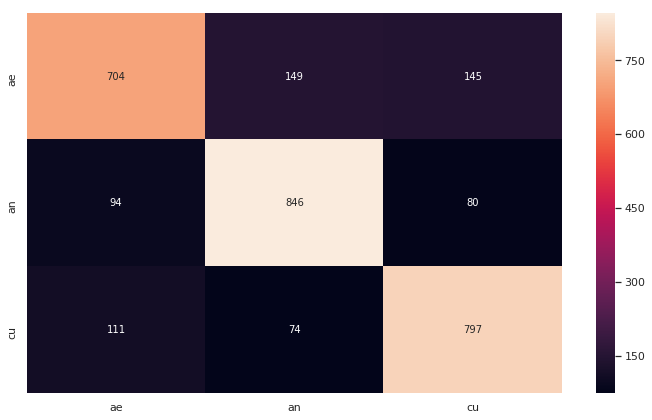

In [14]:
# Making a dataframe of the confusion matrix to plot it
df_cm = pd.DataFrame(cm, index=[i for i in classes], 
                    columns=[i for i in classes])
plt.figure(figsize=(12,7))
sn.heatmap(df_cm, annot=True, fmt='g')

plt.show()

In [15]:
sub = np.concatenate((X, labelarray.reshape(-1,1)), axis=1)
sub = pd.DataFrame(sub)
sub.sort_values(by=2500, inplace=True)

In [16]:
sub.values.shape

(15000, 2501)

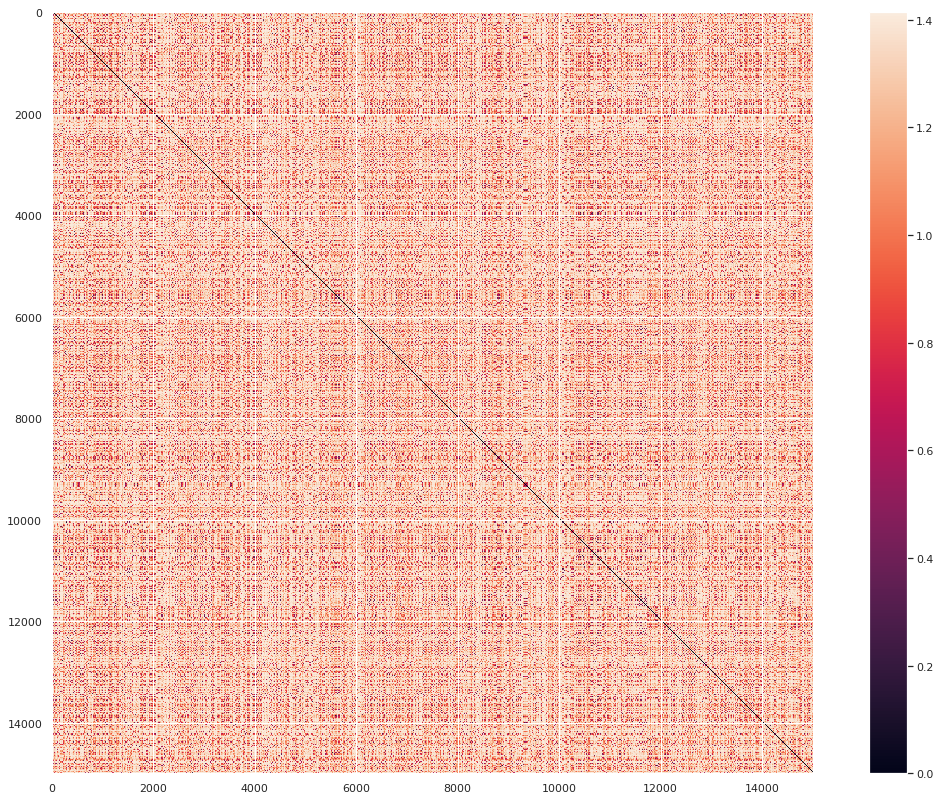

In [17]:
from scipy.spatial.distance import pdist, squareform
D = squareform(pdist(sub.values[:,:-1], metric='euclidean'))
#‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, 
#‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘kulsinski’, 
#‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, 
#‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’.

plt.figure(figsize=(20,14))
plt.imshow(D)
plt.colorbar()

In [18]:
def find_median_signal(D=None):
    a = np.nanmedian(D, axis=0)
    minval = np.argmin(a[np.nonzero(a)])
    return minval # index - argmin

In [19]:
import numpy as np
from scipy.spatial.distance import euclidean

from fastdtw import fastdtw

distance, path = fastdtw(X[:,4], X[:,3], dist=euclidean)
print(distance)

TypeError: unhashable type: 'slice'

In [ ]:
sub = pd.DataFrame(X).T
sub.columns[sub.isna().any()].tolist()

In [ ]:
sub.iloc[:,856].plot()